In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip
import pandas as pd
import anndata
import seaborn as sns
from utilities import load_mquad, load_cellsnp
import mquad

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

## Load p-values data

In [2]:
sample_name = "P4_ST_vis_rep1"
civet_path = "/home/linxy29/data/spaceclone/cSCC/" + sample_name + "/civet_res/"
civet_pval_file = civet_path + "civet_noRandom_minDP5.csv"
civet_pval = pd.read_csv(civet_pval_file).drop(columns="Unnamed: 0").rename(columns={"snp":"variant"})
civet_pval.head

<bound method NDFrame.head of         variant  Tumor_KC_Basal  Tumor_KC_Cyc  Tumor_KC_Diff       value
0          1G>A             NaN           NaN            NaN  Wald_pvals
1          2A>C             NaN           NaN            NaN  Wald_pvals
2          3T>G             NaN           NaN            NaN  Wald_pvals
3          4C>A             NaN           NaN            NaN  Wald_pvals
4          5A>T             NaN           NaN            NaN  Wald_pvals
...         ...             ...           ...            ...         ...
82840  16565C>G             NaN           NaN            NaN     LRT_fdr
82841  16566G>T             NaN           NaN            NaN     LRT_fdr
82842  16567A>C             NaN           NaN            NaN     LRT_fdr
82843  16568T>A             NaN           NaN            NaN     LRT_fdr
82844  16569G>A             NaN           NaN            NaN     LRT_fdr

[82845 rows x 5 columns]>

In [3]:
# Step 1: Reshape the DataFrame to Long Format
value_vars = ['Tumor_KC_Basal', 'Tumor_KC_Cyc', 'Tumor_KC_Diff']
df_long = civet_pval.melt(id_vars=['variant', 'value'], value_vars=value_vars,
                  var_name='Category', value_name='number')

# Step 2: Remove NaN Values
df_long = df_long.dropna(subset=['number'])

# Step 3: Pivot the DataFrame to Separate 'Wald_pvals' and 'LRT_fdr'
df_pivot = df_long.pivot_table(index=['variant', 'Category'], 
                               columns='value', values='number').reset_index()

# Remove rows with NaN in 'Wald_pvals', 'LRT_pvals', or 'LRT_fdr'
df_pivot = df_pivot.dropna(subset=['Wald_pvals', 'LRT_pvals', 'LRT_fdr'])

# Step 4: Calculate the Logarithmic Values
df_pivot['log_Wald_pvals'] = np.log(df_pivot['Wald_pvals'])
df_pivot['log_LRT_pvals'] = np.log(df_pivot['LRT_pvals'])
df_pivot['log_LRT_fdr'] = np.log(df_pivot['LRT_fdr'])

print(df_pivot.head)


<bound method NDFrame.head of value  variant        Category   LRT_fdr  LRT_pvals   LR_vals  Wald_pvals  \
0      1000T>A  Tumor_KC_Basal  1.000000   0.698146  0.150408    0.679008   
1      1000T>A    Tumor_KC_Cyc  1.000000   0.531122  0.392245    0.606706   
2      1000T>A   Tumor_KC_Diff  0.973794   0.366384  0.815893    0.302159   
3      1001C>A  Tumor_KC_Basal  1.000000   0.718210  0.130214    0.710777   
4      1001C>A    Tumor_KC_Cyc  1.000000   1.000000 -1.712866    0.604209   
...        ...             ...       ...        ...       ...         ...   
22687   998A>C    Tumor_KC_Cyc  0.999724   0.528088  0.398069    0.510438   
22688   998A>C   Tumor_KC_Diff  0.933128   0.188694  1.727783    0.165793   
22689   999C>A  Tumor_KC_Basal  1.000000   0.687707  0.161579    0.703079   
22690   999C>A    Tumor_KC_Cyc  0.987205   0.446037  0.580704    0.520041   
22691   999C>A   Tumor_KC_Diff  0.939420   0.209777  1.572962    0.114678   

value  log_Wald_pvals  log_LRT_pvals  log_LRT

/home/linxy29/.conda/envs/maester/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


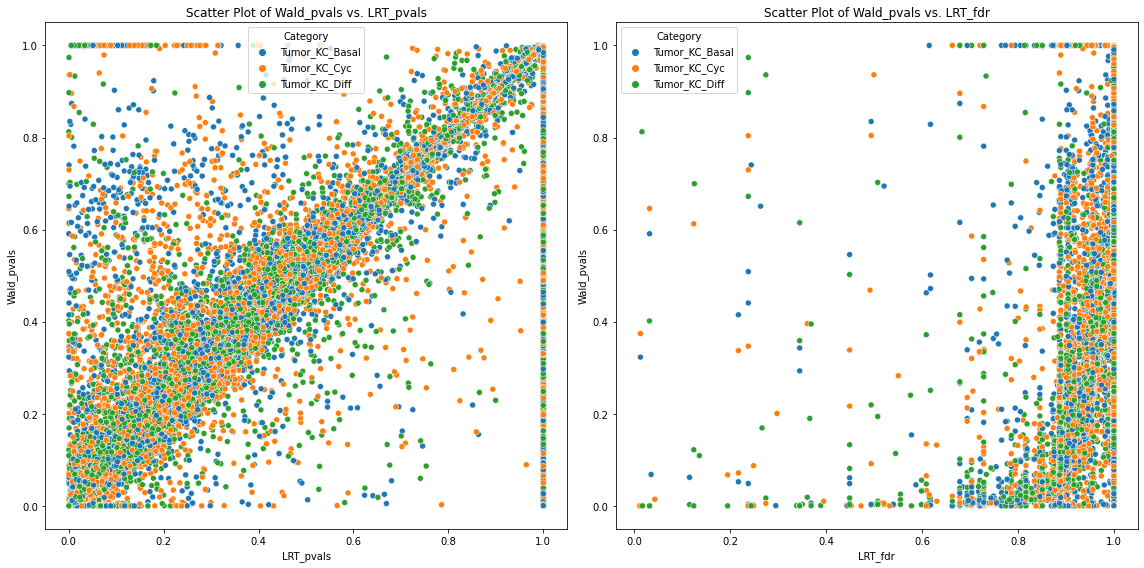

In [4]:
# Step 4: Plot the Data with Two Subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First Subplot: Wald_pvals vs. LRT_pvals
sns.scatterplot(ax=axes[0], data=df_pivot, x='LRT_pvals', y='Wald_pvals', hue='Category')
axes[0].set_xlabel('LRT_pvals')
axes[0].set_ylabel('Wald_pvals')
axes[0].set_title('Scatter Plot of Wald_pvals vs. LRT_pvals')
axes[0].legend(title='Category')

# Second Subplot: Wald_pvals vs. LRT_fdr
sns.scatterplot(ax=axes[1], data=df_pivot, x='LRT_fdr', y='Wald_pvals', hue='Category')
axes[1].set_xlabel('LRT_fdr')
axes[1].set_ylabel('Wald_pvals')
axes[1].set_title('Scatter Plot of Wald_pvals vs. LRT_fdr')
axes[1].legend(title='Category')

plt.tight_layout()
plt.savefig(civet_path + "pvals_dotplot.pdf")
plt.show()

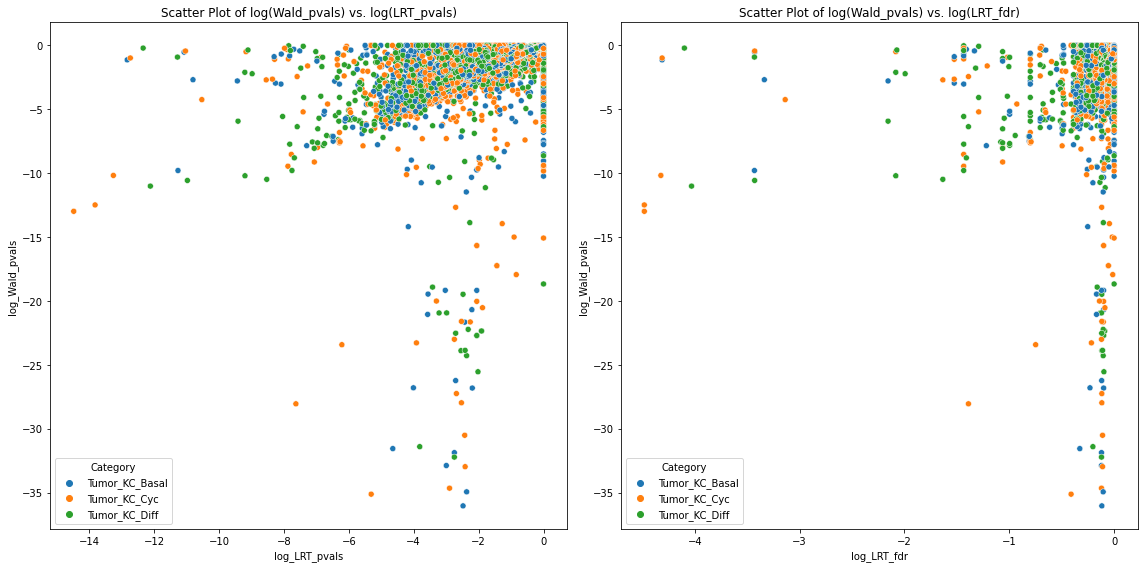

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First Subplot: Wald_pvals vs. LRT_pvals
sns.scatterplot(ax=axes[0], data=df_pivot, x='log_LRT_pvals', y='log_Wald_pvals', hue='Category')
axes[0].set_xlabel('log_LRT_pvals')
axes[0].set_ylabel('log_Wald_pvals')
axes[0].set_title('Scatter Plot of log(Wald_pvals) vs. log(LRT_pvals)')
axes[0].legend(title='Category')

# Second Subplot: Wald_pvals vs. LRT_fdr
sns.scatterplot(ax=axes[1], data=df_pivot, x='log_LRT_fdr', y='log_Wald_pvals', hue='Category')
axes[1].set_xlabel('log_LRT_fdr')
axes[1].set_ylabel('log_Wald_pvals')
axes[1].set_title('Scatter Plot of log(Wald_pvals) vs. log(LRT_fdr)')
axes[1].legend(title='Category')

plt.tight_layout()
plt.savefig(civet_path + "log_pvals_dotplot.pdf")
plt.show()

## Load SNP information

In [6]:
cellsnp_folder = "/home/linxy29/data/spaceclone/cSCC/" + sample_name + "/cellSNP0/"
cSCC_cellsnp, cSCC_barcode = load_cellsnp(cellsnp_folder)
cSCC_cellsnp.variants = [f"{x.split('_')[1]}{x.split('_')[2]}>{x.split('_')[3]}" for x in cSCC_cellsnp.variants]
print("The dimension of the AD data is: ", cSCC_cellsnp.ad.shape)
print("The dimension of the DP data is: ", cSCC_cellsnp.dp.shape)
print("The number of mtSNPs is: ", len(cSCC_cellsnp.variants))

Loaded VCF file: /home/linxy29/data/spaceclone/cSCC/P4_ST_vis_rep1/cellSNP0/cellSNP.cells.vcf.gz
16569 variants detected
variant names detected
The dimension of the AD data is:  (16569, 750)
The dimension of the DP data is:  (16569, 750)
The number of mtSNPs is:  16569


## Check out the results

In [7]:
## calculate mean and variance of variants
af = np.divide(cSCC_cellsnp.ad, cSCC_cellsnp.dp, where=cSCC_cellsnp.dp!=0)
af[np.isnan(af)] = 0
## get the mean of af
mean_af = np.mean(af, axis=1)
variance_af = np.var(af, axis=1)
SNR_af = np.divide(mean_af, variance_af, where=variance_af!=0)
## create a dataframe to store the mean and variance of af
af_statsitics = pd.DataFrame({'variant':cSCC_cellsnp.variants, 'mean_af': mean_af, 'variance_af': variance_af, 'SNR_af': SNR_af})
df_pivot = pd.merge(df_pivot, af_statsitics, on='variant', how='left')
print(af_statsitics.head)

<bound method NDFrame.head of         variant   mean_af  variance_af         SNR_af
0          1G>A  0.000000     0.000000  1.158892e-310
1          2A>C  0.000000     0.000000  4.635574e-310
2          3T>G  0.006000     0.005631   1.065593e+00
3          4C>A  0.000000     0.000000   0.000000e+00
4          5A>T  0.000444     0.000148   3.004005e+00
...         ...       ...          ...            ...
16564  16565C>G  0.002667     0.002660   1.002674e+00
16565  16566G>T  0.000444     0.000148   3.004005e+00
16566  16567A>C  0.004000     0.003317   1.205788e+00
16567  16568T>A  0.000000     0.000000   0.000000e+00
16568  16569G>A  0.000000     0.000000   0.000000e+00

[16569 rows x 4 columns]>


In [8]:
test = np.in1d(af_statsitics['variant'], df_pivot['variant'])
print(len(test))

16569


In [9]:
use_test = 'Wald_pvals'
use_cutoff = 0.01
df_pivot = df_pivot.sort_values(by=[use_test]).sort_values(by='SNR_af', ascending=False)
print(df_pivot.head)
sig_test_variant = df_pivot[df_pivot[use_test] < use_cutoff]['variant'].unique()
print(len(sig_test_variant))
print(sig_test_variant[:5])

<bound method NDFrame.head of         variant        Category   LRT_fdr  LRT_pvals    LR_vals  Wald_pvals  \
21504   9758T>A  Tumor_KC_Basal  0.445072   0.001527  10.045448    0.000807   
21506   9758T>A   Tumor_KC_Diff  1.000000   0.561269   0.337512    0.555721   
21505   9758T>A    Tumor_KC_Cyc  0.895346   0.086263   2.942763    0.069778   
16485   7352A>T  Tumor_KC_Basal  0.959324   0.310114   1.030190    0.330500   
16487   7352A>T   Tumor_KC_Diff  0.987205   0.452481   0.564429    0.439023   
...         ...             ...       ...        ...        ...         ...   
1205   10539T>A  Tumor_KC_Basal  1.000000   0.648166   0.208220    0.672395   
1206   10539T>A    Tumor_KC_Cyc  0.889468   0.070070   3.281388    0.003884   
11655   3804C>A   Tumor_KC_Diff  1.000000   0.614044   0.254328    0.625705   
18767   8583C>A  Tumor_KC_Basal  0.987205   0.456812   0.553694    0.757310   
18768   8583C>A   Tumor_KC_Diff  0.989369   0.468091   0.526479    0.455379   

       log_Wald_pvals